# Data scraping, preparation, exploration, and pre-processing

## Data scraping

We scrape article metadata using the New York Times API. For our project we will analyze articles published between May 15th, 2023 and May 14th, 2024. We start by importing a few libraries and setting up the API.  
> **Note:** In order to run the following code you will need to create an account on (https://developer.nytimes.com) and obtain your own API key. You will then need to create a file `keys.py` in your local repo directory, and save your API key as a string under the variable name `NYT_API_KEY`.  

In [1]:
import pandas as pd
from pynytimes import NYTAPI
from datetime import datetime
from keys import NYT_API_KEY

nyt_api = NYTAPI(NYT_API_KEY, parse_dates=True)
data_loc = 'data/nyt_metadata.csv'


We then fetch the data one month at a time and store in a new `.csv` file. Note that the API has a limit of 5 calls per minute (see the API [FAQ's](https://developer.nytimes.com/faq#a11)), so we need to make sure to wait until 12 seconds between consecutive calls. Note that there is also a limit of 500 calls a day.  
We wrap the process in a function so we can easily adjust the start and end date or change the path of the destination file. The function will also check whether the file already exists, and in that case give a warning before executing the procedure. This will help control the risk of restarting the relatively time-consuming process and limit unnecessary calls to the NYT servers.  
Since we are only interested in articles, we also filter out all other document types during the process.  

In [2]:
from os import listdir
from dateutil.rrule import rrule, MONTHLY
from time import sleep

def scrape(start_date: datetime, end_date: datetime, dest: str=data_loc) -> None:
    # Avoid restarting the process if the .csv already exists...
    execute = dest.split('/')[-1] not in listdir(''.join(dest.split('/')[:-1]))
    # ...unless the user confirms otherwise.
    if not execute:
        execute = input(f'A file already exists at `{dest}`. Do you want to continue?').lower() in ['y', 'yes']
    
    if execute:
        df = pd.DataFrame()
        for month in rrule(MONTHLY, dtstart=start_date, until=end_date):
            print(f'Working on the month of {month}')
            monthly_df = pd.DataFrame(nyt_api.archive_metadata(date=month))
            monthly_df = monthly_df.loc[monthly_df.pub_date.apply(lambda x: str(x)) >= str(start_date)]
            monthly_df = monthly_df.loc[monthly_df.pub_date.apply(lambda x: str(x)) < str(end_date)]
            monthly_df = monthly_df.loc[monthly_df.document_type=='article']
            if not monthly_df.empty:
                df = pd.concat([df, monthly_df]) if not df.empty else monthly_df
            sleep(12)   # The NYT servers have a limit of 5 calls per minute.
        
        df.to_csv(dest)

In [3]:
scrape(datetime(2023, 5, 15), datetime(2024, 5, 15))

Working on the month of 2023-05-15 00:00:00
Working on the month of 2023-06-15 00:00:00
Working on the month of 2023-07-15 00:00:00
Working on the month of 2023-08-15 00:00:00
Working on the month of 2023-09-15 00:00:00
Working on the month of 2023-10-15 00:00:00
Working on the month of 2023-11-15 00:00:00
Working on the month of 2023-12-15 00:00:00
Working on the month of 2024-01-15 00:00:00
Working on the month of 2024-02-15 00:00:00
Working on the month of 2024-03-15 00:00:00
Working on the month of 2024-04-15 00:00:00
Working on the month of 2024-05-15 00:00:00


## Exploration

Let us start by reading the dataframe created above and taking a look at general information. Some of the fields have the string `' '` as value, which pandas does not recognised as null by dafault.

In [4]:
df = pd.read_csv(data_loc, na_values=[' '])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42625 entries, 0 to 42624
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        42625 non-null  int64  
 1   abstract          42623 non-null  object 
 2   web_url           42625 non-null  object 
 3   snippet           42462 non-null  object 
 4   lead_paragraph    42479 non-null  object 
 5   print_section     25732 non-null  object 
 6   print_page        25732 non-null  float64
 7   source            42625 non-null  object 
 8   multimedia        42625 non-null  object 
 9   headline          42625 non-null  object 
 10  keywords          42625 non-null  object 
 11  pub_date          42625 non-null  object 
 12  document_type     42625 non-null  object 
 13  news_desk         42624 non-null  object 
 14  section_name      42619 non-null  object 
 15  subsection_name   16890 non-null  object 
 16  byline            42625 non-null  object

We are interested in the columns `'abstract'`, `'snippet'`, and `'lead_paragraph'`. We see above that these columns contain null values, so let us check exactly how many.

In [5]:
columns = ['abstract', 'snippet', 'lead_paragraph']

for column in columns:
    print(df.loc[df[column].isnull()].shape[0])

2
163
146


We can see that the number of rows with null values for the columns of interest is well under 400, i.e. 1% of the total data set, so we may as well ignore those columns.

In [6]:
df = df.dropna(subset=columns)

Now let us take a look at a few rows from the data frame, focusing on the three columns we care about.

In [7]:
df[columns].head()

,abstract,snippet,lead_paragraph
0,"Economic hardship, climate change, political i...","Economic hardship, climate change, political i...",Relative quiet has prevailed along the souther...
1,It’s election night in America. Stay away from...,It’s election night in America. Stay away from...,"The day before Logan Roy died, he delivered a ..."
2,"Tom is stressed in dress shoes, Shiv hides ben...","Tom is stressed in dress shoes, Shiv hides ben...",This article contains spoilers for Episode 8 o...
3,"No corrections appeared in print on Monday, Ma...","No corrections appeared in print on Monday, Ma...",Errors are corrected during the press run when...
4,"Quotation of the Day for Monday, May 15, 2023.","Quotation of the Day for Monday, May 15, 2023.","“For me, it was time to give back the love the..."


There appears to be a strong overlapping between `'abstract'` and `'snippet'`. Let us check how often they actually coincide.

In [8]:
df.loc[df.abstract != df.snippet][['abstract', 'snippet']]

,abstract,snippet
793,"Over 40 years, Dr. John R. Williams nurtured t...","Over 40 years, Dr. John R. Williams nurtured t..."
854,"A fire last week at a mosque in St. Paul, Minn...","A fire last week at a mosque in St. Paul, Minn..."
3030,The indictment said the former president had i...,The indictment said the former president had i...
3712,"The former Treasury secretary, whose new book ...","The former Treasury secretary, whose new book ..."
5236,"Larry L. Householder, the former speaker of th...","Larry L. Householder, the former speaker of th..."
5403,Even as civil rights groups suggest travelers ...,Even as civil rights groups suggest travelers ...
8348,“My thinking is that reading will focus my min...,“My thinking is that reading will focus my min...
8699,An explosion at a political rally on Sunday in...,An explosion at a political rally on Sunday in...
9846,“I love great character growth and fresh plots...,“I love great character growth and fresh plots...
10859,While the former president’s name appeared now...,While the former president’s name appeared now...


Well that was disappointing. It appears the difference is not really significant, so we should discard one of the two columns. We will keep the column that had more non-null values in the original data frame, which is `'abstract'`. Before we start over and include the rows that we had previously dropped, let us check whether `'lead_paragraph'` has the same issue.

In [9]:
df.loc[df.abstract == df.lead_paragraph].shape[0]

15

So `'abstract'` and `'lead_paragraph'` are the same for 15 data points. We can probably ignore this, but let us still take a look at what those values are, just in case these are really null values that we did not expect.

In [10]:
df.loc[df.abstract == df.lead_paragraph][['abstract', 'lead_paragraph']]

,abstract,lead_paragraph
2025,There are a lot of unsettling signals coming f...,There are a lot of unsettling signals coming f...
8807,"In theory, there is no branch in the American ...","In theory, there is no branch in the American ..."
16586,We bring the movies to you.,We bring the movies to you.
20825,What happens when you realize the people in ch...,What happens when you realize the people in ch...
21647,"Things our dads taught us, whether they intend...","Things our dads taught us, whether they intend..."
22911,Want to see new art in New York this weekend? ...,Want to see new art in New York this weekend? ...
25565,A major political party in a major swing state...,A major political party in a major swing state...
26560,"This week, Jillian Steinhauer covers Dara Birn...","This week, Jillian Steinhauer covers Dara Birn..."
26748,"There’s the thing you plan to do, and then the...","There’s the thing you plan to do, and then the..."
30104,What we ask to find out what we really want to...,What we ask to find out what we really want to...


These are all valid entries, so we might as well just keep them.  
Let us start over then, and take a look at a larger set of values.

In [11]:
df = pd.read_csv(data_loc, na_values=[' '])

columns = ['abstract', 'lead_paragraph']
df = df.dropna(subset=columns)

df[columns].head(20)

,abstract,lead_paragraph
0,"Economic hardship, climate change, political i...",Relative quiet has prevailed along the souther...
1,It’s election night in America. Stay away from...,"The day before Logan Roy died, he delivered a ..."
2,"Tom is stressed in dress shoes, Shiv hides ben...",This article contains spoilers for Episode 8 o...
3,"No corrections appeared in print on Monday, Ma...",Errors are corrected during the press run when...
4,"Quotation of the Day for Monday, May 15, 2023.","“For me, it was time to give back the love the..."
5,The 19-year-old French basketball star is the ...,Boris Diaw was passing through Paris in late S...
6,New York City students are struggling with rea...,Good morning. It’s Monday. We’ll look at somet...
7,Results of Turkey’s election.,Turkey’s presidential election appears to be d...
8,Shouldn’t a protest movement led by unions be ...,"For three months, France has been in revolt: D..."
9,A spy drama based on a decades-long manhunt co...,"Between network, cable and streaming, the mode..."


### Some data cleaning and word count

Now that we have selected which columns to work with and cleared out all invalid entries, we should take a closer look at the word count in each piece of text. Before we proceed to that, it might be a good time to do some cleaning, such as bringing all text to lower case and removing irrelevant characters.

In [12]:
def clean_string(s: str) -> str:
    s = s.lower()
    for char in ['\'', '\'s', '’s', ' - ', ' – ', ' — ', '-', '–', '—', '/', '’', '  ']:
        s = s.replace(char, ' ')
    for char in ['.', ',', ';', ':', '?', '!', '\"'] + [str(i) for i in range(10)]:
        s = s.replace(char, '')
    return s

In [13]:
df.abstract = df.abstract.apply(clean_string)
df.lead_paragraph = df.lead_paragraph.apply(clean_string)
df[columns].head(10)

,abstract,lead_paragraph
0,economic hardship climate change political ins...,relative quiet has prevailed along the souther...
1,it election night in america stay away from th...,the day before logan roy died he delivered a f...
2,tom is stressed in dress shoes shiv hides bene...,this article contains spoilers for episode of...
3,no corrections appeared in print on monday may,errors are corrected during the press run when...
4,quotation of the day for monday may,“for me it was time to give back the love they...
5,the year old french basketball star is the mo...,boris diaw was passing through paris in late s...
6,new york city students are struggling with rea...,good morning it monday we ll look at something...
7,results of turkey election,turkey presidential election appears to be des...
8,shouldn t a protest movement led by unions be ...,for three months france has been in revolt dem...
9,a spy drama based on a decades long manhunt co...,between network cable and streaming the modern...


In [14]:
df['abstract_ct'] = df.abstract.apply(lambda x: len([w for w in x.split(' ') if w != '']))
df['lead_par_ct'] = df.lead_paragraph.apply(lambda x: len([w for w in x.split(' ') if w != '']))
ct_columns = ['abstract_ct', 'lead_par_ct']
df[columns+ct_columns].head(10)

,abstract,lead_paragraph,abstract_ct,lead_par_ct
0,economic hardship climate change political ins...,relative quiet has prevailed along the souther...,20,35
1,it election night in america stay away from th...,the day before logan roy died he delivered a f...,11,85
2,tom is stressed in dress shoes shiv hides bene...,this article contains spoilers for episode of...,23,12
3,no corrections appeared in print on monday may,errors are corrected during the press run when...,8,21
4,quotation of the day for monday may,“for me it was time to give back the love they...,7,14
5,the year old french basketball star is the mo...,boris diaw was passing through paris in late s...,25,29
6,new york city students are struggling with rea...,good morning it monday we ll look at something...,24,35
7,results of turkey election,turkey presidential election appears to be des...,4,32
8,shouldn t a protest movement led by unions be ...,for three months france has been in revolt dem...,12,60
9,a spy drama based on a decades long manhunt co...,between network cable and streaming the modern...,28,35


In [15]:
df[ct_columns].describe()

,abstract_ct,lead_par_ct
count,42479.000000,42479.000000
mean,21.255821,43.727748
std,7.250375,25.407026
min,1.000000,1.000000
25%,17.000000,30.000000
50%,22.000000,40.000000
75%,26.000000,52.000000
max,108.000000,340.000000


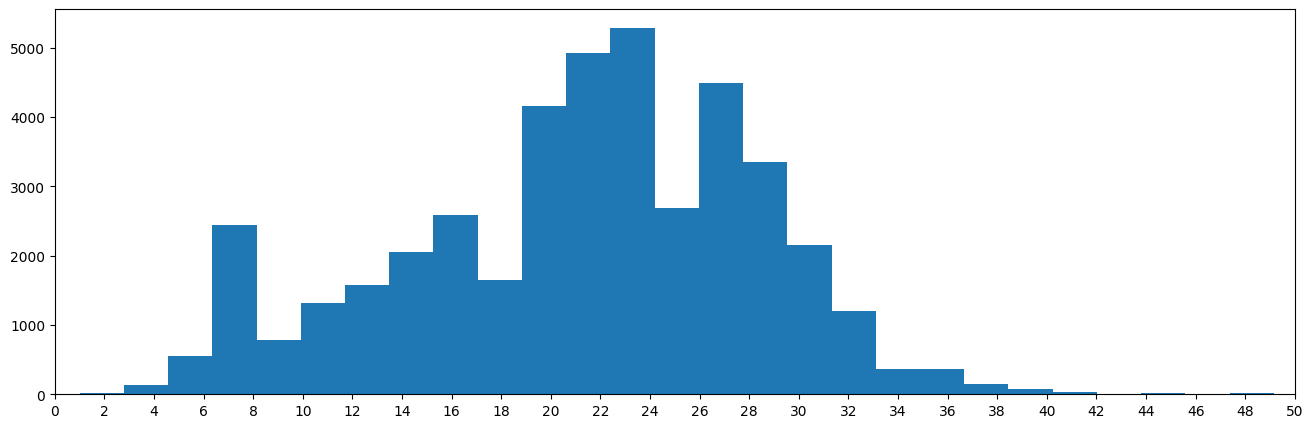

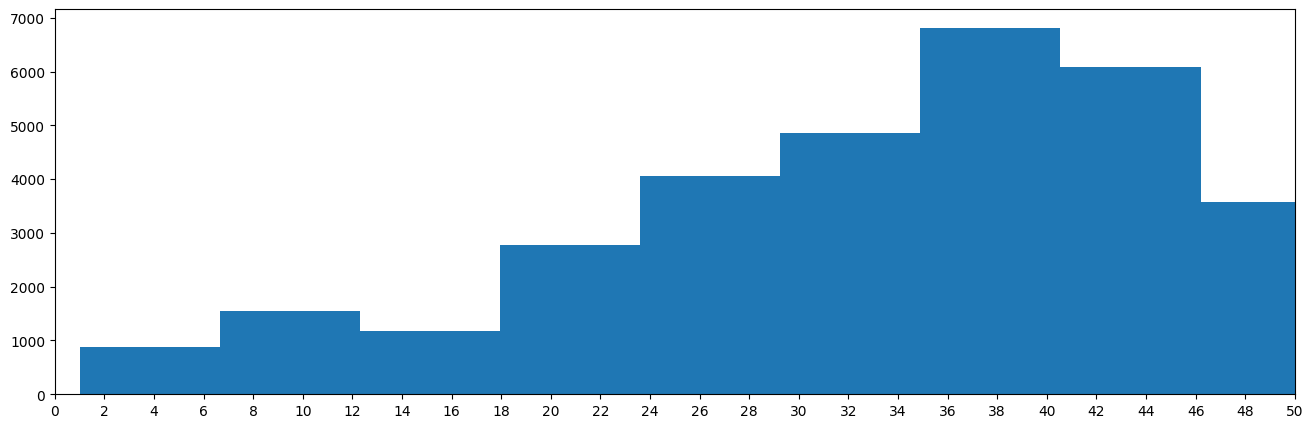

In [16]:
import matplotlib.pyplot as plt

for col in ct_columns:
    plt.figure(figsize=(16,5))
    plt.xlim(xmin=0, xmax=50)
    plt.hist(df[col], bins=60)
    plt.xticks(list(range(0,52,2)))
    plt.show()